In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

## init combined robot config

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, None,
                INDY_IP)]
              , connection_list=[False])

connection_list
[False]


## init stereo aruco detector

In [3]:
from pkg.marker_config import *
from pkg.detector.aruco.stereo import ArucoStereo
from pkg.detector.camera.realsense import RealSense
from pkg.detector.camera.kinect import Kinect
aruco_map = get_aruco_map()
stereo = ArucoStereo(aruco_map, [Kinect(), RealSense()])
stereo.initialize()
# stereo.calibrate()

Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.


Start streaming


In [4]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(stereo, base_link="base_link")
# s_builder.reset_reference_coord(ref_name="floor")

## get ghnd with detected robot config

In [5]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,-np.pi/2))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


## add environment

In [6]:
floor = gscene.create_safe(GEOTYPE.BOX, "floor", "base_link", (3,3,0.01), (0,0,0), 
                           rpy=(0,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
wall = gscene.create_safe(GEOTYPE.BOX, "wall", "base_link", (3,3,0.01), (0,0.2,0), 
                           rpy=(np.pi/2,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
wp1 = gscene.create_safe(GEOTYPE.BOX, "wp1", "base_link", (0.1,0.1,0.01), (0.2,-0.5,0.),rpy=(0,0,np.pi/2), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False)
wp2 = gscene.create_safe(GEOTYPE.BOX, "wp2", "base_link", (0.1,0.1,0.01), (-0.2,-0.5,0), rpy=(0,0,np.pi/2), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False)
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (0.1,0.5,0.01), (0,-0.5,0), rpy=(0,0,np.pi/2), 
                           color=(1,0.7,0.7,0.5), display=True, fixed=True, collision=False)
goal = gscene.create_safe(GEOTYPE.BOX, "goal", "base_link", (0.1,0.1,0.01), (-0.4,-0.3,0), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=True, collision=False)

Please create a subscriber to the marker


In [7]:
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True, exclude_link=["panda1_link7"])

## add brush

In [8]:
gscene.create_safe(gtype=GEOTYPE.BOX, name="brush_body", link_name="base_link", dims=(0.2,0.07,0.02), 
                   center=(0,-0.5,0.045), rpy=(0,0,np.pi/2), color=(0.7,0.7,0.3,1), display=True, collision=True, fixed=False)
gscene.create_safe(gtype=GEOTYPE.BOX, name="brush_handle", link_name="base_link", dims=(0.2,0.03,0.05), center=(0,0,0.035), rpy=(0,0,0), 
                   color=(0.7,0.7,0.3,1), display=True, collision=True, fixed=False, parent="brush_body")
gscene.create_safe(gtype=GEOTYPE.BOX, name="brush_face", link_name="base_link", dims=(0.19,0.06,0.03), center=(0,0,-0.025), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, collision=False, fixed=False, parent="brush_body")

## init planning scene

In [9]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

## Register binders

In [10]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool

In [11]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name="indy0_tcp", 
                 dims=(0.01,)*3, center=(0,0,0.14), rpy=(-np.pi/2,0,0), color=(1,0,0,1), display=True, collision=False, fixed=True)

In [12]:
pscene.create_binder(bname="grip0", gname="grip0", rname="indy0", _type=Gripper2Tool, point=(0,0,0), rpy=(0,0,0))
pscene.create_binder(bname="floor", gname="floor", _type=PlacePlane)
pscene.create_binder(bname="goal_bd", gname="goal", _type=PlacePlane, point=(0,0,0.005), rpy=(0,0,0))
pscene.create_binder(bname="brush_face", gname="brush_face", _type=SweepTool, point=(0,0,-0.015), rpy=(0,0,0))

## add objects

In [13]:
from pkg.planning.constraint.constraint_subject import CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepTask

In [14]:
brush_handle = gscene.NAME_DICT["brush_handle"]
brush_face = gscene.NAME_DICT["brush_face"]
brush = pscene.create_object(oname="brush", gname="brush_body", _type=CustomObject, 
                             action_points_dict = {"handle": Grasp2Point("handle", brush_handle, [0,0,0], [np.pi/2,0,0]),
                                                   "face": PlacePoint("face", brush_face, [0,0,-0.015], [0,0,0])})

In [15]:
sweep = pscene.create_object(oname="sweep", gname="floor", _type=SweepTask, 
                             action_points_dict = {"wp1": SweepPoint("wp1", wp1, [0,0,0.005], [0,0,0]),
                                                   "wp2": SweepPoint("wp2", wp2, [0,0,0.005], [0,0,0])})

### planning pipeline

In [16]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.object_a_star import ObjectAstar
tplan = ObjectAstar(pscene)
tplan.prepare()
from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)
ppline.set_motion(mplan)
ppline.set_sampler(tplan)

## ui

In [17]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production


## Test plan

In [18]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy

initial_state = pscene.update_state(crob.home_pose)

   Use a production WSGI server instead.


In [19]:
# goal_nodes = [("goal",)]
goal_nodes = [("goal", 2)]
ppline.search(initial_state, goal_nodes, verbose=True, display=True, dt_vis=0.01, timeout_loop=300)
schedules = ppline.find_schedules()
schedules_sorted = ppline.sort_schedule(schedules)
snode_schedule = ppline.idxSchedule2SnodeScedule(schedules_sorted[0])

 * Debug mode: off
node: ('floor', 0)->('floor', 1) = fail
node: ('floor', 0)->('grip0', 0) = fail
node: ('floor', 0)->('grip0', 0) = fail
node: ('floor', 0)->('floor', 1) = fail
node: ('floor', 0)->('grip0', 0) = success
Remaining:4->3 / branching: 0->1 (0.46/300.0 s, steps/err: 7(170.247077942 ms)/0.250886552268)
node: ('grip0', 0)->('goal', 0) = success
Remaining:3->2 / branching: 1->2 (0.7/300.0 s, steps/err: 10(244.799137115 ms)/0.00108378221699)
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal', 0)->('goal', 1) = fail
node: ('goal

node: ('grip0', 1)->('goal', 1) = success
Remaining:2->1 / branching: 4->9 (2.61/300.0 s, steps/err: 11(275.132894516 ms)/0.00161812024287)
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goal', 2) = fail
node: ('goal', 1)->('goa

In [20]:
ppline.play_schedule(snode_schedule, period=0.05)

In [21]:
crob.reset_connection([True])

connection_list
[True]
Connect: Server IP (192.168.0.63)


In [26]:
gtimer = GlobalTimer.instance()
gtimer.reset()

In [27]:
with RvizPublisher(gscene, []) as rpub:
    ppline.execute_schedule(snode_schedule, rviz_pub=rpub)

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


In [28]:
gtimer.time_dict.keys()

['send-robot-0']

In [30]:
ppline.gtimer.timelist_dict.keys()

['move_wait', 'rviz']

In [32]:
import matplotlib.pyplot as plt

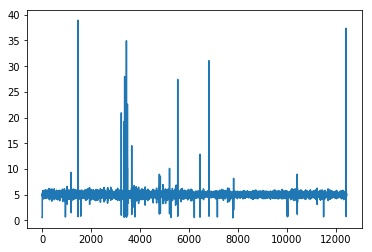

In [33]:
plt.plot(ppline.gtimer.timelist_dict['move_wait'])

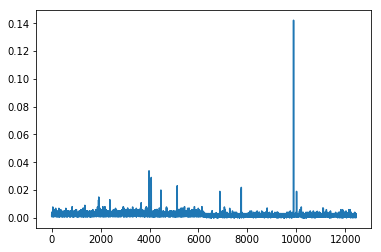

In [34]:
plt.plot(ppline.gtimer.timelist_dict['rviz'])

In [ ]:
for snode in snode_schedule:
    print(snode.state.binding_state)

## Disconnect stereo

In [ ]:
stereo.disconnnect()